In [43]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm

import pickle


from FIESTA_II import *
from functions import *

# Figure 1 -- Reconstructing the CCF

### Read an arbitrary HARPS-N CCF 

In [2]:
V_grid 	= (np.arange(49) - 24) * 0.82
idx 	= (-17<V_grid) & (V_grid<17)
V_grid 	= V_grid[idx]
spacing = np.diff(V_grid)[0]

hdulist = fits.open('Data/r.HARPN.2015-08-29T09:23:58.723_CCF_A.fits')
data    = hdulist[1].data
ccf 	= 1 - data[69,:] / np.mean(data[69,~idx])
ccf 	= ccf[idx]

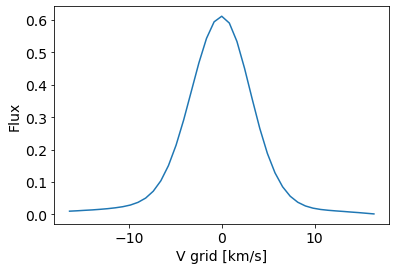

In [3]:
plt.rcParams.update({'font.size': 14})
plt.plot(V_grid, ccf)
plt.xlabel('V grid [km/s]')
plt.ylabel('Flux')
plt.show()

### Calculate the residual rms after the first k modes

In [4]:
A, ϕ, ξ= FT(ccf, spacing)
res_rms 	= np.zeros(ξ.size)
res 		= np.zeros((ξ.size, ccf.size))
ft 			= np.fft.rfft(ccf, ccf.size)
for i in range(ft.size):
	pseudo_ft = copy.copy(ft)
	if i < (ft.size-1):
		pseudo_ft[(i+1):] = 0
	pseudo_ift 	= np.fft.irfft(pseudo_ft, len(ccf))
	res[i,:] 	= pseudo_ift - ccf 
	res_rms[i] 	= np.std(res[i,:])

### Plots

/tmp/ipykernel_12805/539523076.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return np.median(1-ccf)/x
/tmp/ipykernel_12805/539523076.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return np.median(1-ccf)/x


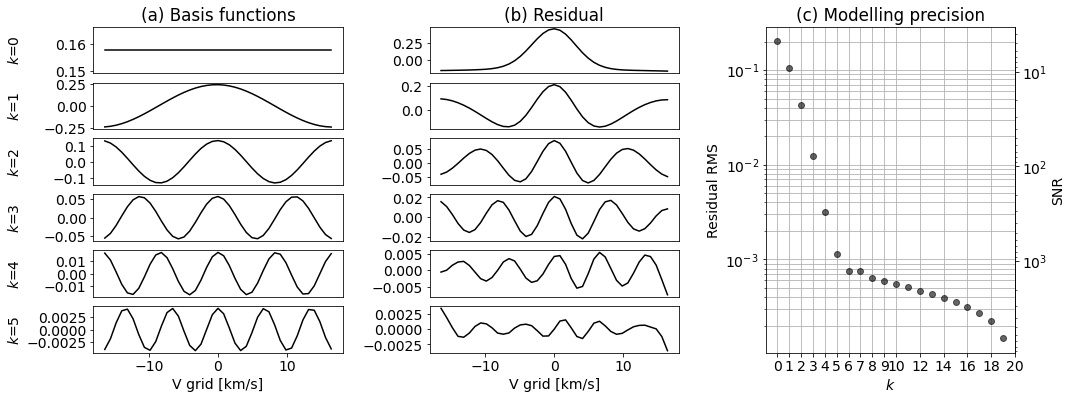

In [5]:
k = 6
fig, axs = plt.subplots(k, 3, figsize=(16, 6))
plt.gcf().subplots_adjust(left=0.1, wspace=0.35)

for i in range(k):
    
    if i == 0:
        axs[i,0].set_title('(a) Basis functions')
        axs[i,1].set_title('(b) Residual')
        axs[i,0].plot(V_grid, (np.mean(ccf))*np.ones(len(V_grid)), 'k-')
    else:
        axs[i,0].plot(V_grid, res[i,:] - res[i-1,:], 'k-')
    
    for j in range(2):
        if i!=k-1:
            axs[i,j].set_xticks([])
        else:
            axs[i,j].set_xlabel('V grid [km/s]')
        
    axs[i,0].set_ylabel(r'$k$=%d' %(i))
    axs[i,1].plot(V_grid, -res[i,:], 'k-')

fig.align_ylabels(axs[:,0])

def SNR(x):
	return np.median(1-ccf)/x
inverse = SNR

ax = plt.subplot(1, 3, 3)
for i in range(ξ.size-1):
	ax.plot(i, res_rms[i], 'ko', alpha = 0.6)
ax.set_title('(c) Modelling precision')
xticks = np.hstack((np.arange(10), np.array([10,12,14,16,18,20])))
ax.set_xticks(xticks)
ax.set_xlabel(r'$k$')
ax.set_yscale('log')
ax.set_ylabel('Residual RMS')
ax.grid(visible=True, which='both')
secax = ax.secondary_yaxis('right', functions=(SNR, inverse))
secax.set_ylabel('SNR')
plt.savefig('Figure/FIESTA_demo.pdf')
plt.show()

# Figure 2 -- Line shift vs line deformation

### Read SOAP CCFs

In [6]:
FILES 	    = sorted(glob.glob('./Data/SOAP-fits/*.fits'))
N_file 	    = len(FILES)
V_grid 	    = (np.arange(401)-200)/10
v_idx 		= (-10 < V_grid) & (V_grid < 10)
V_grid_SOAP = V_grid[v_idx]
CCF 	    = np.zeros((len(V_grid_SOAP), N_file))
eCCF        = np.zeros((len(V_grid_SOAP), N_file))

for n in range(N_file):
    hdulist  = fits.open(FILES[n])
    ccf      = (1 - hdulist[0].data)
    CCF[:,n] = ccf[v_idx]
    if n == 0:
        ccf0 = ccf

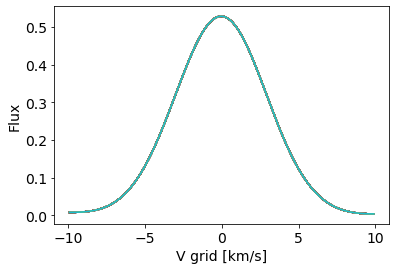

In [7]:
plt.plot(V_grid_SOAP, CCF)
plt.xlabel('V grid [km/s]')
plt.ylabel('Flux')
plt.show()

In [8]:
RV_FT_k, A_k, RV_gauss = FIESTA(V_grid_SOAP, CCF, eCCF, template=CCF[:,0], k_max=10)
RV_FT_k  *= 1000
RV_gauss *= 1000


Velocity grid used [-9.90, 9.90]


### Static, shifted and deformed CCFs

Both the shifted and the deformed CCF show an apparent RV shift of 1.1 m/s

In [9]:
f = interp1d(V_grid, ccf0, kind='cubic')
ccf_shift = f(V_grid_SOAP - RV_gauss[51]/1000)

CCF_plot = np.zeros((CCF.shape[0],3))
CCF_plot[:,0] = CCF[:,0]
CCF_plot[:,1] = ccf_shift
CCF_plot[:,2] = CCF[:,51]

RV = np.zeros(3)
for i in range(3):
    popt, _ = curve_fit(gaussian, V_grid_SOAP, CCF_plot[:,i])
    RV[i]   = popt[1]*1000
print(RV[2]-RV[0], RV[1]-RV[0]) 

1.104690858547329 1.1045753354827994


### FIESTA break down

In [10]:
idx = np.arange(6)

spacing = np.diff(V_grid)[0]

A0, ϕ0, ξ = FT(CCF_plot[:,0], spacing)
A1, ϕ1, ξ = FT(CCF_plot[:,1], spacing)
A2, ϕ2, ξ = FT(CCF_plot[:,2], spacing)

Δϕ1 = wrap(ϕ1-ϕ0)
Δϕ2 = wrap(ϕ2-ϕ0)

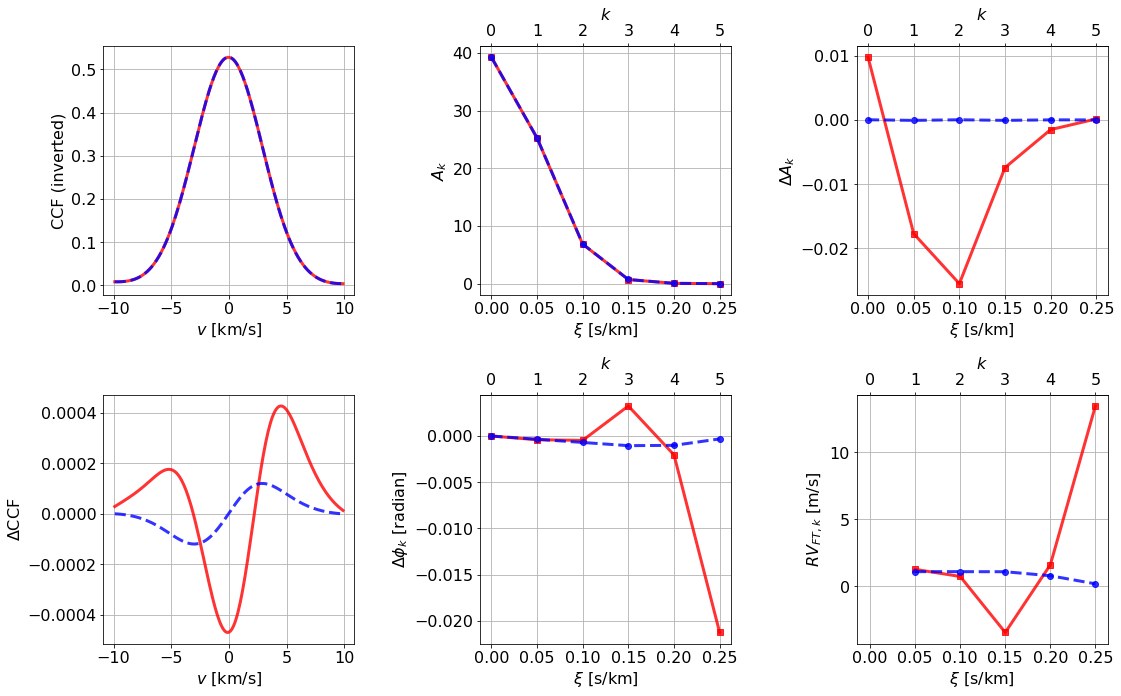

In [11]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 11))
plt.subplots_adjust(hspace=0.4, wspace=0.5)  # the amount of width and height reserved for blank space between subplots
alpha=0.8
lw=3

def mode_number(x):
	return x / np.diff(ξ)[0]
inverse = mode_number

def plot_A_ϕ(x, y1, y2, x_label, y_label):
    ax.plot(x, y2, 'rs-', alpha=alpha, lw=lw)
    ax.plot(x, y1, 'bo--', alpha=alpha, lw=lw)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xticks(x, minor=False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(visible=True, which='both')
    secax = ax.secondary_xaxis('top', functions=(mode_number, inverse))	
    secax.set_xticks(idx, minor=False)
    secax.set_xlabel(r'$k$')

plt.subplot(231)
plt.plot(V_grid_SOAP, CCF_plot[:,2], 'r', alpha=alpha, lw=lw)
plt.plot(V_grid_SOAP, CCF_plot[:,1], 'b--', alpha=alpha, lw=lw)
plt.xlabel(r'$v$ [km/s]')
plt.ylabel('CCF (inverted)')
plt.grid(True)

# Singal deformation #
plt.subplot(234)
plt.plot(V_grid_SOAP, CCF_plot[:,2] - CCF_plot[:,0], 'r', alpha=alpha, lw=lw)
plt.plot(V_grid_SOAP, CCF_plot[:,1] - CCF_plot[:,0], 'b--', alpha=alpha, lw=lw)
plt.xlabel(r'$v$ [km/s]')
plt.ylabel(r'$\Delta$CCF')
plt.grid(True)

# A_k #
ax = fig.add_subplot(232)
plot_A_ϕ(x=ξ[idx], y1=A1[idx], y2=A2[idx], x_label=r'$\xi$ [s/km]', y_label=r'$A_k$')

# ΔA_k #
ax = fig.add_subplot(233)
plot_A_ϕ(x=ξ[idx], y1=A1[idx]-A0[idx], y2=A2[idx]-A0[idx], x_label=r'$\xi$ [s/km]', y_label=r'$\Delta A_k$')

ax = fig.add_subplot(235)
plot_A_ϕ(x=ξ[idx], y1=Δϕ1[idx], y2=Δϕ2[idx], x_label=r'$\xi$ [s/km]', y_label=r'$\Delta \phi_k$ [radian]')

# shift spectrum #
ax = fig.add_subplot(236)
rv2 = np.zeros(len(Δϕ2))
rv2[1:] = - Δϕ2[1:] / (2 * np.pi * ξ[1:])
rv1 = np.zeros(len(Δϕ1))
rv1[1:] = - Δϕ1[1:] / (2 * np.pi * ξ[1:])
ax.plot(ξ[1:6], rv2[1:6]*1000, 'rs-', alpha=alpha, lw=lw)
ax.plot(ξ[1:6], rv1[1:6]*1000, 'bo--', alpha=alpha, lw=lw)
ax.set_xlim(-0.015, 0.265)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xticks(ξ[idx], minor=False)
ax.set_xlabel(r'$\xi$ [s/km]')
ax.set_ylabel(r'$RV_{FT,k}$ [m/s]')
ax.grid(visible=True, which='both')
secax = ax.secondary_xaxis('top', functions=(mode_number, inverse))	
secax.set_xticks(idx, minor=False)
secax.set_xlabel(r'$k$')
plt.savefig('Figure/comparison_noise-free.pdf')
plt.show()

# Figure 3 -- $RV_\textrm{FT,k}$ and the weighted mean

Following the RV_FT_k, A_k and RV_gauss of Figure 2

### $RV_\textrm{FT,k}$

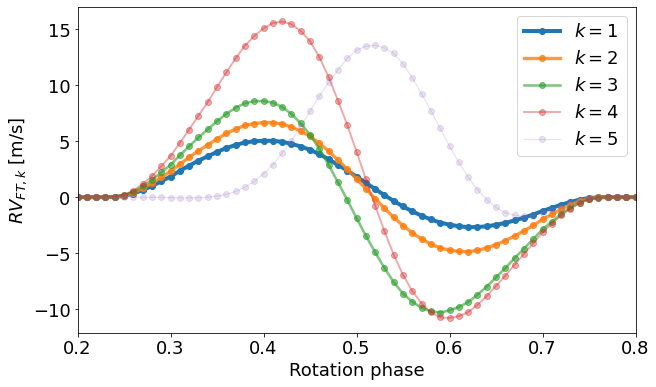

In [12]:
plt.rcParams.update({'font.size': 18})
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

rotation_phase = np.linspace(0,1,100,endpoint=False)
fig, axes = plt.subplots(figsize=(10, 6))
for i in range(5):
	plt.plot(rotation_phase, RV_FT_k[i,:], color=colors[i], lw=4-i*0.7, marker='o', alpha=1-i*0.2, label=r'$k={}$'.format(i+1))
plt.xlim([0.2,0.8])
plt.xlabel('Rotation phase')
plt.ylabel(r'$RV_{FT, k}$ [m/s]')
plt.legend()
plt.savefig('Figure/FIESTA_II_insight_RV_k.pdf')
plt.show()

### The weighted mean

In [13]:
rv_weighted = np.zeros(RV_FT_k.shape[1])
for i in range(RV_FT_k.shape[1]):
	rv_weighted[i] = sum(RV_FT_k[:,i] * A_k[:,i]) / np.sum(A_k[:,i])

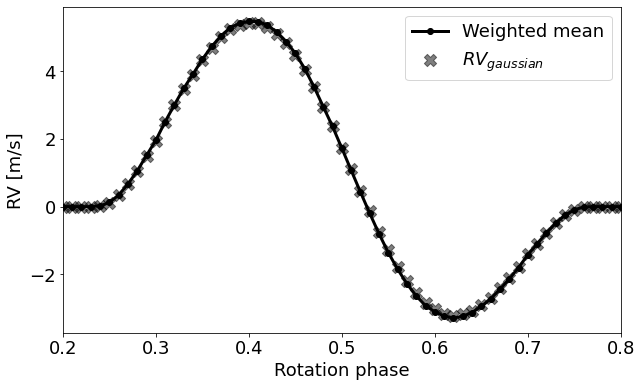

In [14]:
fig, axes = plt.subplots(figsize=(10, 6))
plt.plot(rotation_phase, rv_weighted, marker='o', lw=3, color='black', alpha=1, label='Weighted mean')
plt.scatter(rotation_phase, RV_gauss, marker='X', s=150, color='black', lw=1, label=r'$RV_{gaussian}$', alpha=0.5)
plt.xlabel('Rotation phase')
plt.ylabel('RV [m/s]')
plt.xlim([0.2,0.8])
plt.legend(loc=1)
plt.savefig('Figure/FIESTA_II_insight_weighted_mean.pdf')
plt.show()

# Figures 4 and 5 -- Different latitudes for SOAP spots and plages 

In [15]:
def plot_soap_config(FEATURE):
    
    N_sample  = 8
    lat       = np.linspace(10, 80, num=N_sample)
    RV_gauss_all = np.zeros((N_sample, 100))
    ΔA_k_all = np.zeros((N_sample, 5, 100))
    Δv_k_all = np.zeros((N_sample, 5, 100))

    for i in range(N_sample):
        print('\nlatitude = ' + str(lat[i]))
        folder_name = 'CCF_PROT=25.05_i=90.00_lon=(180.0,0.0,0.0,0.0)_lat=(' + '%.1f' % lat[i] +  ',0.0,0.0,0.0)_size=(0.1000,0.0000,0.0000,0.0000)'
        DIR     = 'Data/' + FEATURE + '_lat/' + folder_name
        FILE    = sorted(glob.glob(DIR + '/fits/*fits'))
        N       = len(FILE)

        for n in range(N):
            hdulist     = fits.open(FILE[n])
            CCF[:, n]   = hdulist[0].data[v_idx]

        v_k, A_k, RV_gauss = FIESTA(V_grid_SOAP, CCF, eCCF=CCF*0, template=CCF[:,0], k_max=5)
        v_k *= 1000
        RV_gauss = (RV_gauss - RV_gauss[0]) * 1000
        RV_gauss_all[i,:] = RV_gauss

        ΔA_k_all[i,:,:] = np.array([A_k[:,kk] - A_k[:,0] for kk in range(100)]).T

        for k in range(v_k.shape[0]):
            v_k[k,:] -= RV_gauss
        Δv_k_all[i,:,:] = v_k  

    # 
    colors = cm.seismic(np.linspace(0, 1, RV_gauss_all.shape[0]))

    plt.rcParams.update({'font.size': 12})
    fig, axes = plt.subplots(5,2,figsize=(8, 6)) 
    plt.subplots_adjust(left = 0.15, hspace=0.1, wspace=0.35, top = 0.95, right = 0.95)  # the amount of width and height reserved for blank space between subplots

    phase = np.arange(100)/100
    idx = (phase<=0.8) & (phase>=0.2)

    for i in range(5):

        for j in range(N_sample):
            axes[i,0].plot(phase[idx], ΔA_k_all[j,i,idx], alpha=0.8, color=colors[7-j], label=r'$%d\degree$' %lat[j])
            axes[i,1].plot(phase[idx], Δv_k_all[j,i,idx], alpha=0.8, color=colors[7-j])
        axes[i,0].set_ylabel(r'$k$=%d' %(i+1))
        axes[i,1].set_ylabel('[m/s]')
        axes[0,0].set_title(FEATURE + r' $\Delta A_k$')
        axes[0,1].set_title(FEATURE + r' $\Delta RV_k$')

        if i == 1:            
            axes[i,0].legend(fontsize=6, loc=3)

        for l in range(2):
            if i!=4:
                axes[i,l].set_xticks([])
            else:
                axes[i,l].set_xlabel('Rotation phase') 

    fig.align_ylabels(axes[:,0])
    fig.align_ylabels(axes[:,1])
    plt.savefig('Figure/FIESTA-' + FEATURE + '_latitude.pdf')
    plt.show()

    RV_gauss = RV_gauss.reshape(-1, 1)
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(figsize=(20, 4))
    fig.tight_layout()
    plt.subplots_adjust(left=0.06, bottom=0.16, right=0.98, top=0.9, wspace=0.4, hspace=0.4)

    for j in range(5):  
        ax = plt.subplot(1, 5, j+1)
        for i in range(RV_gauss_all.shape[0]):
            ax.plot(RV_gauss_all[i,:], Δv_k_all[i,j,:], '.-', alpha=0.8, color=colors[7-i], label=r'$%d\degree$' %lat[i])
            ax.set_xlabel(r'$RV_{Gaussian}$ [m/s]')
            ax.set_ylabel(r'$\Delta RV_{}$ [m/s]'.format(j+1))
            if FEATURE == 'spot':
                if j==0:
                    ax.legend(prop={'size': 10})
            if j==2:
                ax.set_title('Solar '+ FEATURE)
    plt.savefig('Figure/FIESTA-' + FEATURE + '_latitude_correlation.pdf')
    plt.show()


latitude = 10.0

Velocity grid used [-9.90, 9.90]

latitude = 20.0

Velocity grid used [-9.90, 9.90]

latitude = 30.0

Velocity grid used [-9.90, 9.90]

latitude = 40.0

Velocity grid used [-9.90, 9.90]

latitude = 50.0

Velocity grid used [-9.90, 9.90]

latitude = 60.0

Velocity grid used [-9.90, 9.90]

latitude = 70.0

Velocity grid used [-9.90, 9.90]

latitude = 80.0

Velocity grid used [-9.90, 9.90]


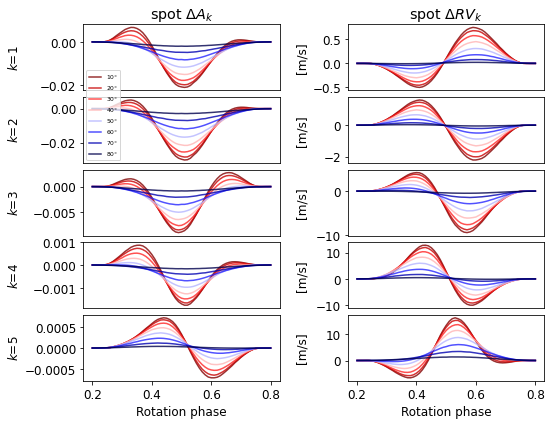

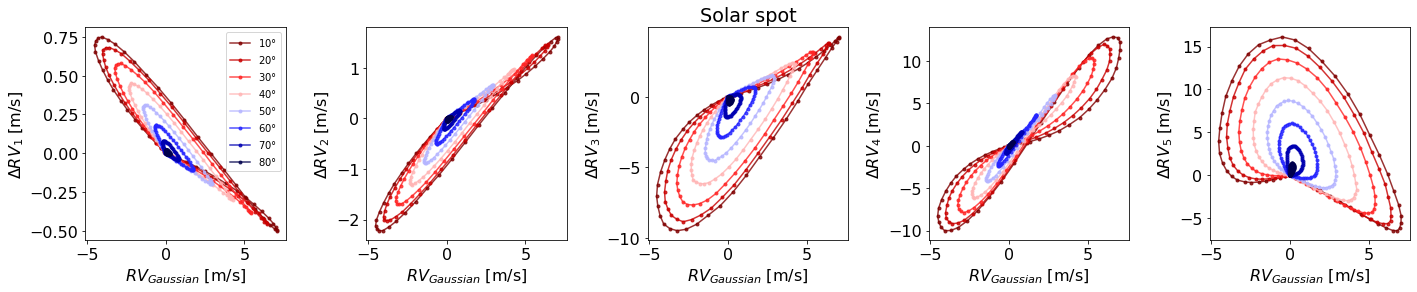

In [16]:
plot_soap_config('spot')


latitude = 10.0

Velocity grid used [-9.90, 9.90]

latitude = 20.0

Velocity grid used [-9.90, 9.90]

latitude = 30.0

Velocity grid used [-9.90, 9.90]

latitude = 40.0

Velocity grid used [-9.90, 9.90]

latitude = 50.0

Velocity grid used [-9.90, 9.90]

latitude = 60.0

Velocity grid used [-9.90, 9.90]

latitude = 70.0

Velocity grid used [-9.90, 9.90]

latitude = 80.0

Velocity grid used [-9.90, 9.90]


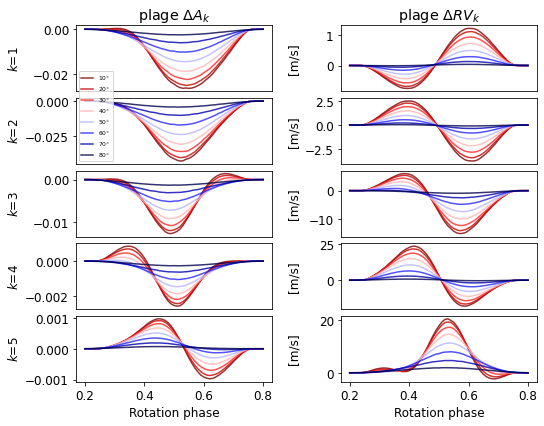

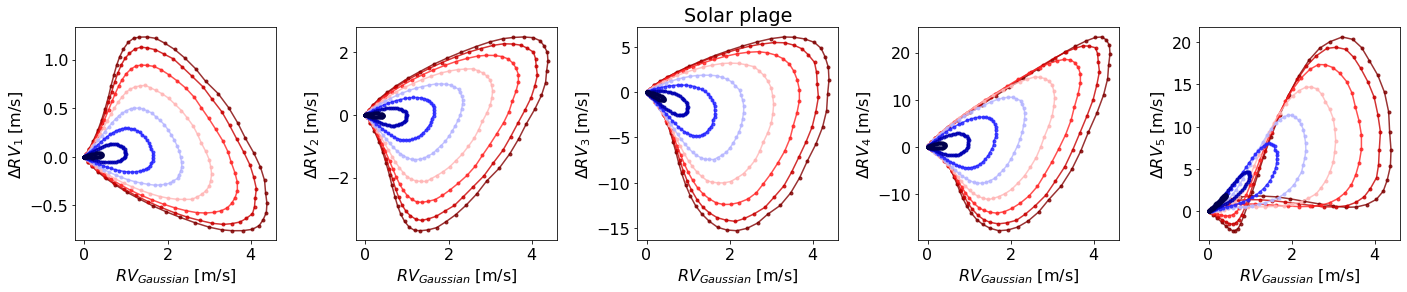

In [17]:
plot_soap_config('plage')

# Figure 6 -- Simulated continuous solar observations

### Read CCFs

In [32]:
N_file 	= 730
V_grid 	= (np.arange(151)-75)/5
idx 	= (-6 < V_grid) & (V_grid < 6)
V_grid 	= V_grid[idx]
CCF 	= np.zeros((len(V_grid), N_file))
t       = np.arange(730)

for i in range(N_file):
	CCF[:,i] = np.loadtxt('Data/CCF/CCF'+str(i+1)+'.txt')[idx]
	CCF[:,i] = 1 - CCF[:,i]/max(CCF[:,i])

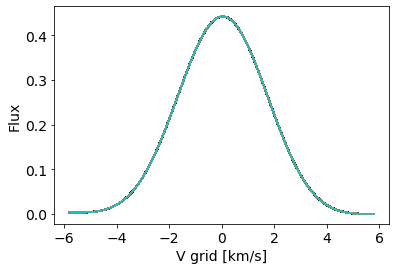

In [33]:
plt.rcParams.update({'font.size': 14})
plt.plot(V_grid, CCF)
plt.xlabel('V grid [km/s]')
plt.ylabel('Flux')
plt.show()

### FIESTA - obtain $RV_\textrm{FT,k}$ and $A_k$

In [34]:
RV_FT_k, A_k, RV_gauss = FIESTA(V_grid, CCF, eCCF=CCF*0, k_max=6, template=[])

RV_FT_k *=1000
RV_gauss *= 1000

k_mode = RV_FT_k.shape[0]
ΔRV_k = np.zeros(RV_FT_k.shape)
for i in range(k_mode):
	ΔRV_k[i,:] = RV_FT_k[i,:] - RV_gauss


Velocity grid used [-5.80, 5.80]


### Plot results

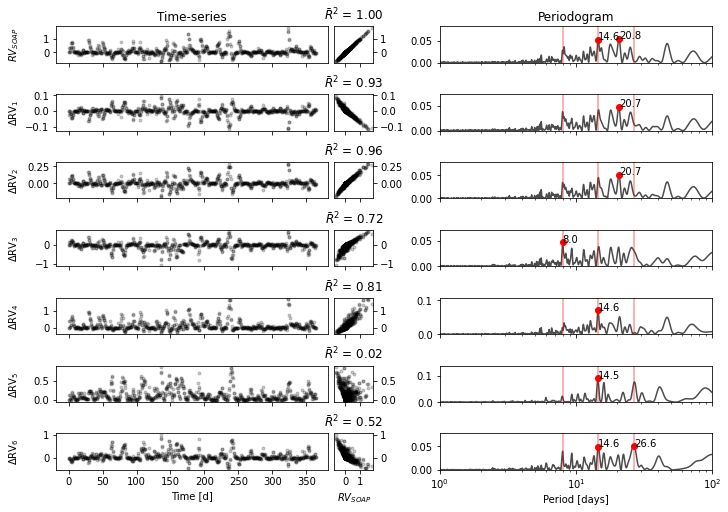

In [36]:
from sklearn.linear_model import LinearRegression

alpha1 = 0.2
plt.rcParams.update({'font.size': 10})
lw = 2
widths = [7,1,7]
heights = [1,1,1,1,1,1,1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig6, f6_axes = plt.subplots(figsize=(10, k_mode+1), ncols=3, nrows=7, constrained_layout=True,
                             gridspec_kw=gs_kw)
for r, row in enumerate(f6_axes):
	for c, ax in enumerate(row):		
		if c==0:
			if r==0:
				ax.plot(t/2, RV_gauss, 'k.', alpha = alpha1)
				ax.set_title('Time-series')
				ax.set_ylabel('$RV_{SOAP}$')
			else:				
				ax.plot(t/2, ΔRV_k[r-1,:], 'k.', alpha = alpha1)
				ax.set_ylabel(r'$\Delta$RV$_{%d}$' %(r))
			if r!=k_mode:
				ax.tick_params(labelbottom=False)
			else:
				ax.set_xlabel('Time [d]')
		if c==1:
			if r==0:
				reg = LinearRegression().fit(RV_gauss.reshape(-1, 1), RV_gauss.reshape(-1, 1))
				score = reg.score(RV_gauss.reshape(-1, 1), RV_gauss.reshape(-1, 1))
				adjust_R2 = 1-(1-score)*(N_file-1)/(N_file-1-1)
				title = r'$\bar{R}$' + r'$^2$'
				ax.set_title(title + ' = {:.2f}'.format(adjust_R2))
				ax.plot(RV_gauss, RV_gauss, 'k.', alpha = alpha1)				
			if r>0:
				reg = LinearRegression().fit(RV_gauss.reshape(-1, 1), ΔRV_k[r-1,:].reshape(-1, 1))
				score = reg.score(RV_gauss.reshape(-1, 1), ΔRV_k[r-1,:].reshape(-1, 1))
				adjust_R2 = 1-(1-score)*(N_file-1)/(N_file-1-1)
				title = r'$\bar{R}$' + r'$^2$'
				ax.set_title(title + ' = {:.2f}'.format(adjust_R2))				
				ax.plot(RV_gauss, ΔRV_k[r-1,:], 'k.', alpha = alpha1)
			if r!=k_mode:
				ax.tick_params(labelbottom=False)
			else:
				ax.set_xlabel('$RV_{SOAP}$')
			ax.yaxis.tick_right()

		if c==2:
			if r==0:
				periodogram6(ax, t/2, RV_gauss, vlines=[8.0, 14.6, 26.6])
				ax.set_title('Periodogram')
			if r>0:
				periodogram6(ax, t/2, ΔRV_k[r-1,:], vlines=[8.0, 14.6, 26.6])
			if r!=k_mode:
				ax.tick_params(labelbottom=False)
			if r==k_mode:
				ax.set_xlabel('Period [days]')
fig6.align_ylabels(f6_axes[:, 0])				
plt.savefig('Figure/SOAP_FIESTA.pdf')
plt.show()

# Figures 7 and 8 -- HARPS-N

### Read CCFs

In [37]:
with open('Data/harps_n.plk','rb') as plkfile:
    V_grid, CCF_daily, eCCF_daily, bjd_daily, rv_daily, rv_raw_daily, erv_daily = pickle.load(plkfile).values()

49 velocities in V_grid; 567 daily binned CCFs and RVs

In [38]:
V_grid.shape, CCF_daily.shape, rv_daily.shape

((49,), (49, 567), (567,))

CCFs are normalised and inverted

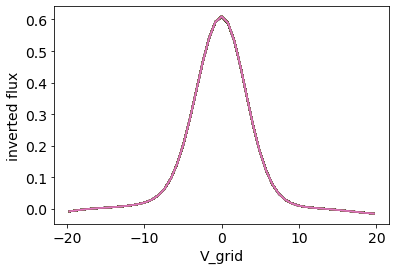

In [39]:
plt.rcParams.update({'font.size': 14})
plt.plot(V_grid, CCF_daily)
plt.xlabel('V_grid')
plt.ylabel('inverted flux')
plt.show()

### FIESTA - obtain $RV_\textrm{FT,k}$ and $A_k$

In [40]:
k_max = 20
df, RV_FT_k, eRV_FT_k, A_k, eA_k, RV_gauss = FIESTA(V_grid, CCF_daily, eCCF_daily, k_max=k_max)

RV_FT_k  *= 1000
eRV_FT_k *= 1000
RV_gauss *= 1000
ΔRV_k     = RV_FT_k - rv_raw_daily


Velocity grid used [-16.40, 15.58]
The median SNR of all CCFs is 45695
The user-defined SNR = 2.0

ξ_photon = 0.61
ξ_normal = 0.61
ξ_individual = 0.61
ξ_timeseries = 0.34

In summary, the cut-off frequency is recommended to be 0.34 (k_max = 11)

        ξ  individual_SNR  ts_SNR_A  ts_SNR_ϕ  modelling noise  \
0   0.000         77015.7      44.5       0.0          0.20289   
1   0.030         61318.7      40.8     105.8          0.10292   
2   0.061         33224.0      27.4     110.2          0.04021   
3   0.091         13533.7      15.1      66.9          0.01114   
4   0.122          3806.4      10.6      26.2          0.00253   
5   0.152           816.6       5.9       8.5          0.00097   
6   0.183           269.1       4.5       3.8          0.00060   
7   0.213            59.7       3.6       4.4          0.00057   
8   0.244           108.1       3.0       2.8          0.00048   
9   0.274            67.5       2.5       2.2          0.00044   
10  0.305            61.1  

### Plot time-series

$A_k$

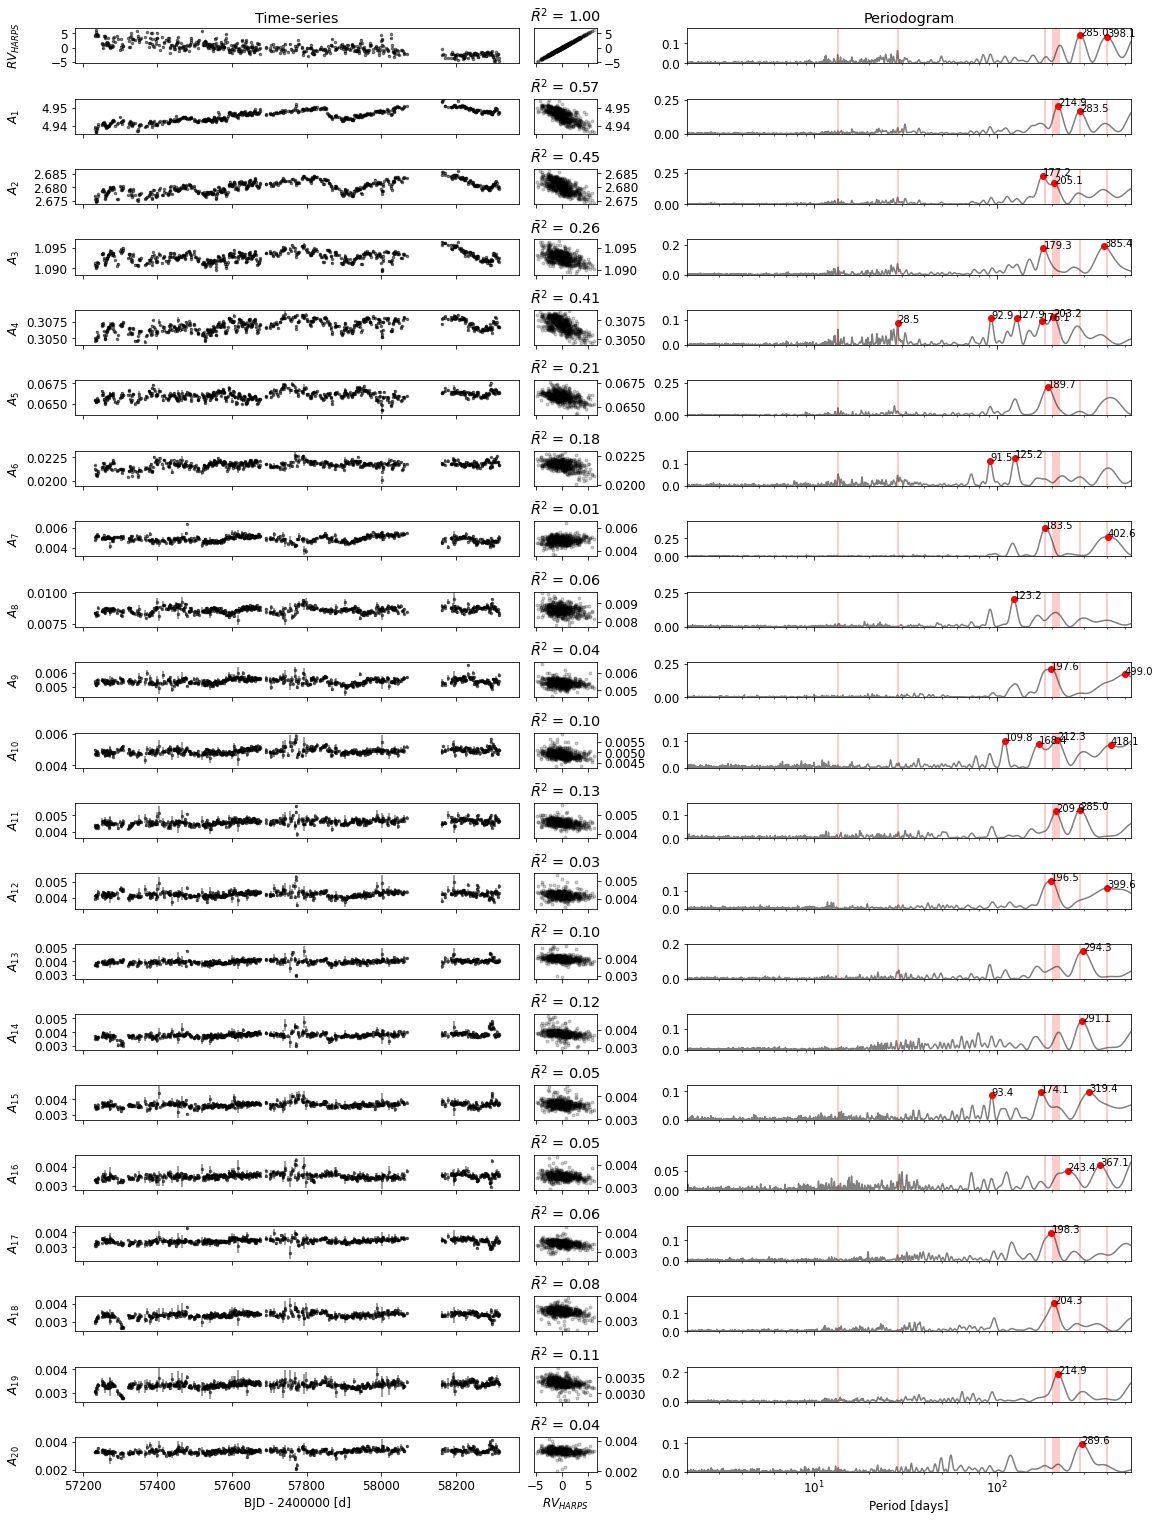

In [41]:
plot_all(k_mode=k_max, t=bjd_daily, rv=rv_daily, erv=erv_daily, 
        vlines = [13.4, 28.5, 365/2, 285, 400],
        ind=A_k, eind=eA_k,
        ts_xlabel='BJD - 2400000 [d]', 
        rv_xlabel='$RV_{HARPS}$', 
        pe_xlabel='Period [days]',
        ind_yalbel=r'$A$',
        file_name='Figure/Amplitude_time-series_correlation_periodogram.pdf')

$\Delta RV_\textrm{k}$

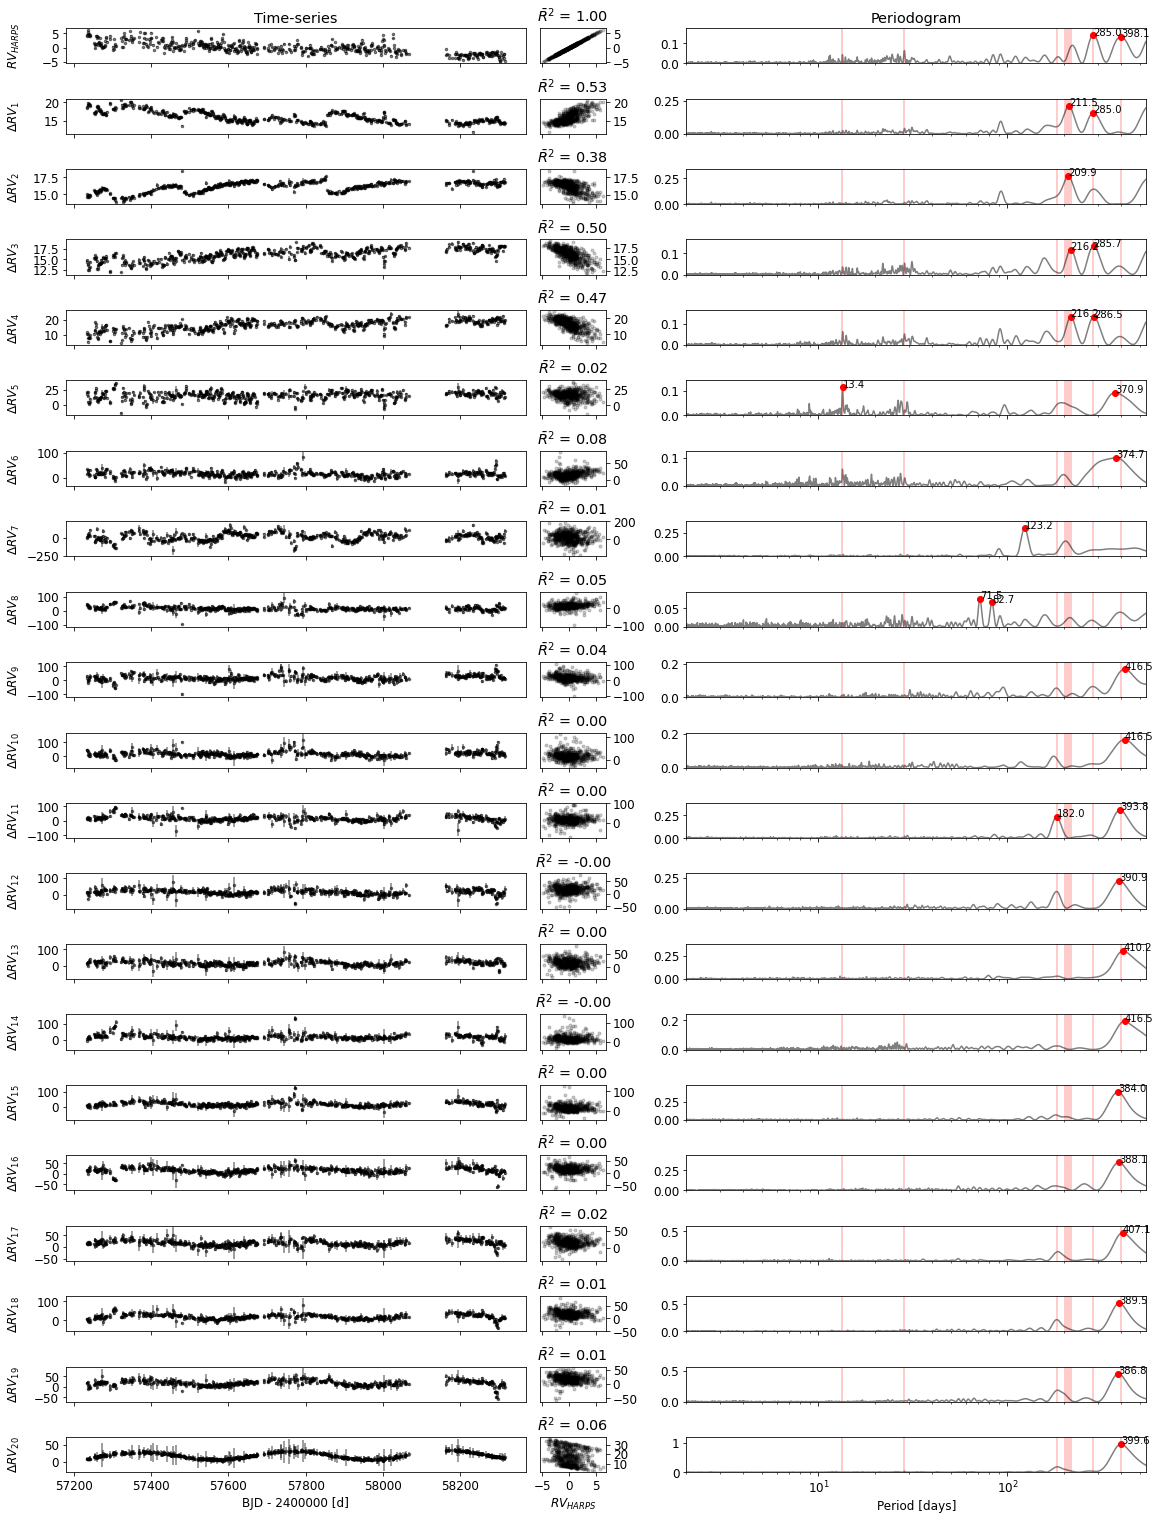

In [42]:
plot_all(k_mode=k_max, t=bjd_daily, rv=rv_daily, erv=erv_daily, 
        vlines = [13.4, 28.5, 365/2, 285, 400],
        ind=ΔRV_k, eind=eRV_FT_k, 
        ts_xlabel='BJD - 2400000 [d]', 
        rv_xlabel='$RV_{HARPS}$', 
        pe_xlabel='Period [days]',
        ind_yalbel=r'$\Delta RV$',
        file_name='Figure/shift_time-series_correlation_periodogram.pdf')

We can then use $A_k$ and $\Delta RV_\textrm{k}$ to trace CCF variability. 

# Figure 9 -- PCA on HARPS-N

We feed the first 9 FIESTA modes into weighted PCA.

### $\Delta RV_\textrm{k}$

In [56]:
k_max = 9
PC, weighted_pca_score, err_weighted_pca_score, n_pca = weighted_pca(X=ΔRV_k[:k_max,:].T, X_err=eRV_FT_k[:k_max,:].T, nor=True)

Cumulative variance explained vs PCA components
1 	 44.271
2 	 62.395
3 	 75.059
4 	 85.683
5 	 92.137
6 	 97.190
7 	 98.638
8 	 99.969
9 	 100.000
5 pca scores account for 92.14% variance explained
Standard deviations of each component and the midean uncertainty are
 [2.  1.3 1.1 1.1 0.9] 
 [0.1 0.2 0.4 0.3 0.3]


We then show the 3 most principal component scores for $\Delta RV_\textrm{k}$.

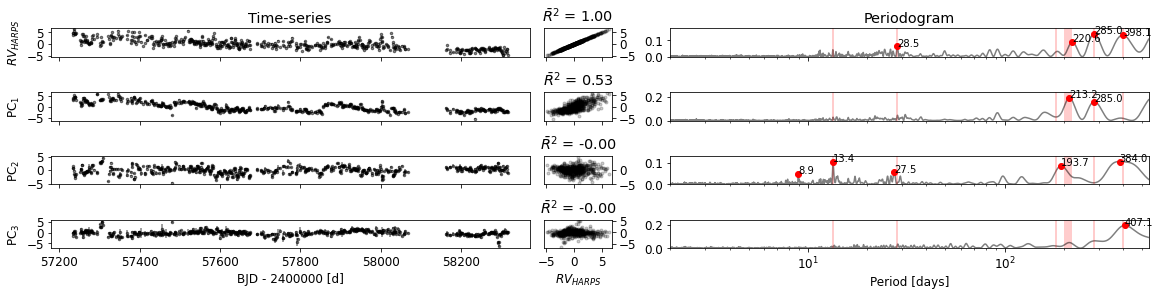

In [57]:
plot_all(k_mode=3, t=bjd_daily, rv=rv_daily, erv=erv_daily, 
    vlines = [13.4, 28.5, 365/2, 285, 400],
    ind=weighted_pca_score.T, eind=err_weighted_pca_score.T, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{HARPS}$', 
    pe_xlabel='Period [days]',
    ind_yalbel='PC',
    height_ratio=0.4,
    file_name='Figure/PCA_delta_RV_k_max={:d}.pdf'.format(k_max))

### $A_k$

Same analysis for $A_k$; not presented in the paper.

Cumulative variance explained vs PCA components
1 	 47.089
2 	 66.832
3 	 80.513
4 	 86.337
5 	 91.909
6 	 96.230
7 	 98.676
8 	 99.745
9 	 100.000
5 pca scores account for 91.91% variance explained
Standard deviations of each component and the midean uncertainty are
 [2.1 1.4 1.2 0.8 0.8] 
 [0.1 0.3 0.3 0.4 0.3]


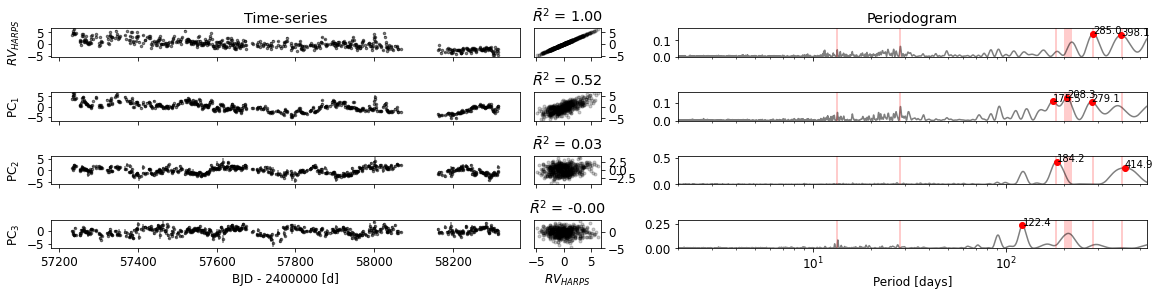

In [58]:
PC2, weighted_pca_score2, err_weighted_pca_score2, n_pca2 = weighted_pca(X=A_k[:9,:].T, X_err=eA_k[:9,:].T, nor=True)

plot_all(k_mode=3, t=bjd_daily, rv=rv_daily, erv=erv_daily, 
    vlines = [13.4, 28.5, 365/2, 285, 400],
    ind=weighted_pca_score2.T, eind=err_weighted_pca_score2.T, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{HARPS}$', 
    pe_xlabel='Period [days]',
    ind_yalbel='PC',
    file_name='Figure/PCA_A_k_max={:d}.pdf'.format(k_max))

# Figure 10 -- Short term and long term variations

In [ ]:
k_feature = 3
short_variation = np.zeros((k_feature, ΔRV_k.shape[1]))
long_variation 	= np.zeros((k_feature, ΔRV_k.shape[1]))

for i in range(k_feature):
    _, short_variation[i,:], long_variation[i,:] = long_short_divide(
        x=bjd_daily, y=weighted_pca_score[:,i], yerr=err_weighted_pca_score[:,i], r=100)
    
plot_all_but_corr(k_mode=6, t=bjd_daily,
    ind=np.vstack([short_variation, long_variation]), 
    eind=np.vstack([err_weighted_pca_score[:,0:3].T, err_weighted_pca_score[:,0:3].T]),
    ts_xlabel='BJD - 2400000 [d]', 
    height_ratio = 0.81,
    pe_xlabel='Period [days]',
    ind_yalbel=['S-PC$_1$','S-PC$_2$','S-PC$_3$','L-PC$_1$','L-PC$_2$','L-PC$_3$'],
    file_name='Figure/LS-term_variation.pdf')

In [68]:
def plot_all_but_corr(k_mode, t, ind, eind, height_ratio, ts_xlabel, pe_xlabel, ind_yalbel, file_name):

	'''
	e.g. 
		k_mode 		= 11
		t 			= bjd_daily
		ind 		= shift_function
		eind 	 	= err_shift_spectrum
		ts_xlabel 	= 'BJD - 2400000 [d]'
		pe_xlabel 	= 'Period [days]'
		ind_yalbel	= 'A'
		file_name 	= 'time-series_and_shift_correlation.png'

	'''
	def new_periodogram(x, y, dy, height_ratio=height_ratio, plot_min_t=2, max_f=1, spp=100):
	
		from scipy.signal import find_peaks
		from astropy.timeseries import LombScargle

		time_span = (max(x) - min(x))
		min_f   = 1/time_span

		frequency, power = LombScargle(x, y, dy).autopower(minimum_frequency=min_f,
													   maximum_frequency=max_f,
													   samples_per_peak=spp)

		plot_x = 1/frequency
		idxx = (plot_x>plot_min_t) & (plot_x<time_span/2)
		height = max(power[idxx])*height_ratio
		ax.plot(plot_x[idxx], power[idxx], 'k-', alpha=0.5)
		peaks, _ = find_peaks(power[idxx], height=height)
		ax.plot(plot_x[idxx][peaks], power[idxx][peaks], "ro")

		for n in range(len(plot_x[idxx][peaks])):
			ax.text(plot_x[idxx][peaks][n], power[idxx][peaks][n], '%.1f' % plot_x[idxx][peaks][n], fontsize=10)

		ax.set_xlim([plot_min_t,time_span/2])
		ax.set_ylim([0, 1.25*max(power[idxx])])

		ax.set_xscale('log')

	from sklearn.linear_model import LinearRegression

	# set up the plotting configureations
	alpha1, alpha2 = [0.5,0.2]
	widths 	= [7,7]
	heights = [1]*k_mode
	gs_kw 	= dict(width_ratios=widths, height_ratios=heights)
	plt.rcParams.update({'font.size': 12})
	fig6, f6_axes = plt.subplots(figsize=(16, k_mode), ncols=2, nrows=k_mode, constrained_layout=True,
	                             gridspec_kw=gs_kw)

	# plots 
	for r, row in enumerate(f6_axes):
		for c, ax in enumerate(row):	

			# time-series 
			if c==0:
				ax.errorbar(t, ind[r,:], eind[r,:],  marker='.', ms=5, color='black', ls='none', alpha=alpha1)
				if len(ind_yalbel)==1:
					ax.set_ylabel(ind_yalbel[0] + '$_{' + str(r+1) + '}$')
				else:
					ax.set_ylabel(ind_yalbel[r])
				if r==0:
					ax.set_title('Time-series')
				if r!=(k_mode-1):
					ax.set_xticks([])
				if r==(k_mode-1):
					ax.set_xlabel(ts_xlabel)

			if c==1:
				new_periodogram(t, ind[r,:], eind[r,:])
				if r==0:
					ax.set_title('Periodogram')
				if r!=(k_mode-1):
					ax.set_xticks([])
				if r==(k_mode-1):
					ax.set_xlabel(pe_xlabel)

	fig6.align_ylabels(f6_axes[:, 0])
	plt.savefig(file_name)
	plt.show() 
	plt.close('all')